In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd

C:\Users\b8008458\AppData\Local\Temp\ipykernel_12628\2182633286.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# set location
place = "Newcastle Upon Tyne, United Kingdom"

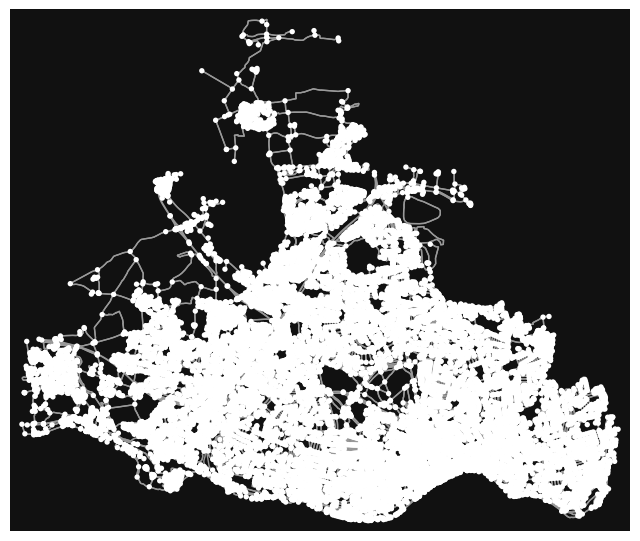

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# obtain street network and plot
g = ox.graph_from_place(place, network_type='all')
ox.plot_graph(ox.project_graph(g))

In [4]:
# convert to a gdf
gdf = ox.graph_to_gdfs(g, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(g, nodes=True, edges=False)

In [5]:
# set crs
gdf = gdf.to_crs(3857)
gdf_nodes = gdf_nodes.to_crs(3857)

In [6]:
# Find "neighbourhood" roads
neighbourhoods = gdf.loc[~((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') | 
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == '30 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph')) |
                        # combined queries
                        ((gdf['highway'] == 'residential') & (gdf['maxspeed'] != '30 mph'))
                        )]

In [7]:
# Find "boundary" roads
boundary_roads = gdf.loc[((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') | 
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph')) |
                        # combined queries
                        ((gdf['highway'] == 'residential') & (gdf['maxspeed'] == '30 mph'))
                        )]

In [8]:
boundary_roads.explore()

In [9]:
# create a tiny buffer around the boundary roads
boundary_roads_buffer = boundary_roads.buffer(1)

# reset buffer geoSeries to a geoDataFrame
boundary_roads_buffer_gdf = gpd.GeoDataFrame(gpd.GeoSeries(boundary_roads_buffer))
boundary_roads_buffer_gdf = boundary_roads_buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')

In [10]:
# cut the full network be the boundary roads
clipped = gpd.overlay(gdf,boundary_roads_buffer_gdf, how='difference')

In [11]:
clipped

osmid  oneway lanes  ref                 highway  \
0                     694138960   False   NaN  NaN                cycleway   
1                     694138960   False   NaN  NaN                cycleway   
2        [353650784, 353650924]   False   NaN  NaN        [steps, footway]   
3                     694138960   False   NaN  NaN                cycleway   
4                     299924336   False   NaN  NaN                 footway   
...                         ...     ...   ...  ...                     ...   
52532                1185235039   False   NaN  NaN                 service   
52533                  70696090   False   NaN  NaN             residential   
52534                  70696090   False   NaN  NaN             residential   
52535                1185235039   False   NaN  NaN                 service   
52536  [1185233994, 1185233996]   False   NaN  NaN  [service, residential]   

      maxspeed reversed  length  \
0          NaN    False  98.357   
1          NaN     True  31.641   
2          NaN     True  38.503   
3          NaN     True  54.549   
4          NaN     True  35.040   
...        ...      ...     ...   
52532      NaN    False  41.951   
52533      NaN    False  17.598   
52534      NaN     True  20.311   
52535      NaN     True  41.951   
52536      NaN    False  39.627   

                                                geometry bridge access  \
0      LINESTRING (-178132.759 7356085.832, -177977.1...    NaN    NaN   
1      LINESTRING (-178132.759 7356085.832, -178182.6...    NaN    NaN   
2      LINESTRING (-178132.759 7356085.832, -178125.1...    NaN    yes   
3      LINESTRING (-177876.735 7356200.739, -177964.4...    NaN    NaN   
4      LINESTRING (-177876.735 7356200.739, -177882.4...    NaN    NaN   
...                                                  ...    ...    ...   
52532  LINESTRING (-185827.474 7362002.707, -185755.7...    NaN    NaN   
52533  LINESTRING (-185755.728 7362017.341, -185749.7...    NaN    NaN   
52534  LINESTRING (-185755.728 7362017.341, -185763.1...    NaN    NaN   
52535  LINESTRING (-185755.728 7362017.341, -185827.4...    NaN    NaN   
52536  LINESTRING (-187292.383 7361556.155, -187277.1...    NaN    NaN   

                 name junction tunnel service width est_width area  
0                 NaN      NaN    NaN     NaN   NaN       NaN  NaN  
1                 NaN      NaN    NaN     NaN   NaN       NaN  NaN  
2                 NaN      NaN    NaN     NaN   NaN       NaN  NaN  
3                 NaN      NaN    NaN     NaN   NaN       NaN  NaN  
4                 NaN      NaN    NaN     NaN   NaN       NaN  NaN  
...               ...      ...    ...     ...   ...       ...  ...  
52532             NaN      NaN    NaN     NaN   NaN       NaN  NaN  
52533    Rawlston Way      NaN    NaN     NaN   NaN       NaN  NaN  
52534    Rawlston Way      NaN    NaN     NaN   NaN       NaN  NaN  
52535             NaN      NaN    NaN     NaN   NaN       NaN  NaN  
52536  Kirkland Chase      NaN    NaN     NaN   NaN       NaN  NaN  

[52537 rows x 18 columns]

c:\Users\b8008458\Anaconda3\envs\clean_ox\Lib\site-packages\osmnx\utils_graph.py:154: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


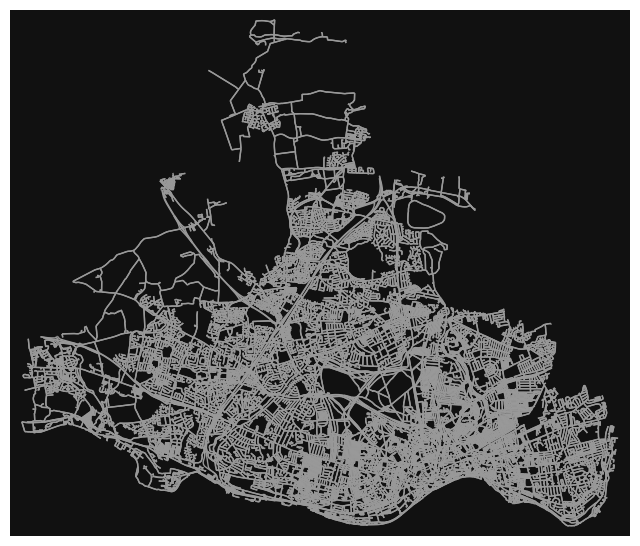

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
# convert back to a graph
clipped_g = ox.graph_from_gdfs(gdf_nodes, gdf)

# plot 
ox.plot_graph(clipped_g)

In [13]:
# Convert the lists in 'maxspeed' column to tuples
gdf['highway'] = gdf['highway'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Find all unique values in the 'maxspeed' column
unique_maxspeed_values = gdf['highway'].unique()

# Print the unique values
print(unique_maxspeed_values)


['trunk' 'trunk_link' 'cycleway' ('steps', 'footway') 'footway'
 'secondary' 'unclassified' ('unclassified', 'cycleway')
 ('pedestrian', 'cycleway') 'service' 'pedestrian' 'tertiary' 'primary'
 ('unclassified', 'pedestrian') 'motorway' 'residential'
 ('residential', 'cycleway') ('service', 'pedestrian')
 ('footway', 'service') 'secondary_link' 'motorway_link'
 ('path', 'unclassified') 'path' ('path', 'residential')
 ('pedestrian', 'residential') 'steps' ('residential', 'pedestrian')
 ('unclassified', 'residential') ('unclassified', 'footway')
 'primary_link' ('service', 'residential') ('footway', 'residential')
 ('cycleway', 'residential') ('steps', 'pedestrian')
 ('footway', 'cycleway') ('steps', 'footway', 'residential') 'bridleway'
 ('steps', 'residential') ('footway', 'pedestrian')
 ('unclassified', 'service') ('unclassified', 'steps')
 ('unclassified', 'path') 'track' ('path', 'steps') ('steps', 'cycleway')
 ('path', 'footway') ('footway', 'service', 'residential')
 ('track', 'foo